In [2]:
# Packages
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Constants
eV = 1.5192678e15  # eV to s⁻¹
c_ms = 2.99792458e8  # Speed of light in m/s
nm = 1e-9  # nm to m

# Parameters
w_values = np.linspace(2, 6, 100) * eV
t_values = np.linspace(1, 20, 100) * nm
z_values = np.linspace(1, 20, 100) * nm
kp_max = 10 / (5 * nm)
maxeval = 10000
mediums = ["vacuum", "silica"]

In [3]:
# Dielectric function using the Drude model
def get_eps(w, med):
    """ Returns the dielectric function for a given medium. """
    # Constants
    eb = 9.5
    wp = 9.06 * eV
    g = 0.071 * eV

    if med == "vacuum":
        return 1.0  # Vacuum layer
    elif med == "metal":  # Metal slab (Drude model)
        return eb - (wp**2) / ((w**2) + (1j * w * g))
    elif med == "silica":
        return 4.2  # Approximate dielectric constant of silica
    elif med == "teflon":
        return 2.1  # Approximate dielectric constant of teflon


In [4]:
# Fresnel reflection coefficients for s- and p-polarization
def rij(w, kp, eps1, eps2, pol):
    """ Computes the Fresnel reflection coefficient for given polarization. """
    k = w / c_ms
    kzi = np.sqrt(eps1 * k**2 - kp**2 + 0j)
    kzj = np.sqrt(eps2 * k**2 - kp**2 + 0j)

    if pol == 0:  # s-polarization
        return (kzi - kzj) / (kzi + kzj)
    elif pol == 1:  # p-polarization
        return (eps2 * kzi - eps1 * kzj) / (eps2 * kzi + eps1 * kzj)
        

In [5]:
# Total reflection coefficient for a metallic slab
def rT(w, kp, eps1, eps2, eps3, t, pol):
    """ Computes the total reflection coefficient for a thin slab. """
    k = w / c_ms
    kz2 = np.sqrt(eps2 * k**2 - kp**2 + 0j)

    r12 = rij(w, kp, eps1, eps2, pol)
    r23 = rij(w, kp, eps2, eps3, pol)

    expid = np.exp(2j * kz2 * t)  # Propagation inside slab
    return (r12 + r23 * expid) / (1 + r12 * r23 * expid)

In [13]:
# Function to compute Gxx using integration
def get_G(w, t, z, kp_max, maxeval, medium):
    """ Computes the xx-component of the Green's function via numerical integration. """
    k = w / c_ms
    imG0 = (2 / 3) * k**3
    eps1 = get_eps(w, "vacuum")  # First medium (vacuum)
    eps2 = get_eps(w, "metal")  # Metal slab
    eps3 = get_eps(w, medium)  # Third medium (vacuum, silica, teflon)

    def fxx(kp):
        """ Integrand function for Gxx calculation (complex-valued). """
        kz = np.sqrt(eps1 * k**2 - kp**2 + 0j)  # Wavevector component in z-direction
        expiz2 = np.exp(2j * kz * z)  # Exponential propagation term
        if np.isclose(kp, np.sqrt(eps1) * k, atol=1e-10):
            return 0
        else:
            return 0.5j * kp * expiz2 / kz * (
                rT(w, kp, eps1, eps2, eps3, t, 0) * k**2
                - rT(w, kp, eps1, eps2, eps3, t, 1) * kz**2
            )
 
    def fzz(kp):
        """ Integrand function for Gzz calculation (complex-valued). """
        kz = np.sqrt(eps1 * k**2 - kp**2 + 0j)
        expiz2 = np.exp(2j * kz * z)
        if np.isclose(kp, np.sqrt(eps1) * k, atol=1e-10):
            return 0
        else:
            return 1j * kp**3 * expiz2 / kz * rT(w, kp, eps1, eps2, eps3, t, 1)

    # Separating real and imaginary integration
    real_Gxx, _ = spi.quad_vec(lambda kp: np.real(fxx(kp)), 0, kp_max, limit=maxeval)
    imag_Gxx, _ = spi.quad_vec(lambda kp: np.imag(fxx(kp)), 0, kp_max, limit=maxeval)

    real_Gzz, _ = spi.quad_vec(lambda kp: np.real(fzz(kp)), 0, kp_max, limit=maxeval)
    imag_Gzz, _ = spi.quad_vec(lambda kp: np.imag(fzz(kp)), 0, kp_max, limit=maxeval)

    return real_Gxx / imG0, imag_Gxx / imG0, real_Gzz / imG0, imag_Gzz / imG0



In [ ]:
# Plotting Gxx and Gzz components variation against frequency
def plot_results_w(x_values, xlabel, title, mediums):
    fig, axes = plt.subplots(2, len(mediums), figsize=(10, 6), sharex=True, sharey="row")

    labels_real = [r"$Re(G_{xx})$", r"$Re(G_{zz})$"]
    labels_imag = [r"$Im(G_{xx})$", r"$Im(G_{zz})$"]
    colors = ["b", "r"]
    linestyles = ["-", "--"]

    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-3, 3))

    for col, medium in enumerate(mediums):
        # Computing real and imaginary components of Gxx and Gzz
        Gxx_r, Gxx_i, Gzz_r, Gzz_i = zip(
            *[get_G(w, 20*nm, 5*nm, kp_max, maxeval, medium) for w in x_values]
        )

        # First row: Real parts
        for ax, data, label, color, linestyle in zip(
            [axes[0, col]] * 2,
            [Gxx_r, Gzz_r],
            labels_real,
            colors,
            linestyles
        ):
            ax.plot(x_values, data, color=color, linestyle=linestyle, label=label)
            ax.yaxis.set_major_formatter(formatter)

        axes[0, col].set_title(f"{title} ({medium.capitalize()})")
        axes[0, col].grid(True, linestyle="--", alpha=0.6)

        # Second row: Imaginary parts
        for ax, data, label, color, linestyle in zip(
            [axes[1, col]] * 2,
            [Gxx_i, Gzz_i],
            labels_imag,
            colors,
            linestyles
        ):
            ax.plot(x_values, data, color=color, linestyle=linestyle, label=label)
            ax.yaxis.set_major_formatter(formatter)

        axes[1, col].set_xlabel(xlabel)
        axes[1, col].grid(True, linestyle="--", alpha=0.6)

    
    fig.text(0.002, 0.75, "Real Components of G", va="center", rotation="vertical", fontsize=10)
    fig.text(0.002, 0.25, "Imaginary Components of G", va="center", rotation="vertical", fontsize=10)

    axes[0, 0].legend()
    axes[1, 0].legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Plotting Gxx and Gzz components variation against distance

def plot_results_z(x_values, xlabel, title, mediums):
    fig, axes = plt.subplots(2, len(mediums), figsize=(10, 5), sharex=True, sharey="row")

    labels_real = [r"$Re(G_{xx})$", r"$Re(G_{zz})$"]
    labels_imag = [r"$Im(G_{xx})$", r"$Im(G_{zz})$"]
    colors = ["b", "r"]
    linestyles = ["-", "--"]

    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((0, 0))

    for col, medium in enumerate(mediums):
        # Computing real and imaginary components of Gxx and Gzz
        Gxx_r, Gxx_i, Gzz_r, Gzz_i = zip(
            *[get_G(2*eV, 20*nm, w, 10/w, maxeval, medium) for w in x_values]
        )

        # First row: Real parts
        for ax, data, label, color, linestyle in zip(
            [axes[0, col]] * 2,
            [Gxx_r, Gzz_r],
            labels_real,
            colors,
            linestyles
        ):
            ax.plot(x_values, data, color=color, linestyle=linestyle, label=label)
            ax.yaxis.set_major_formatter(formatter)

        axes[0, col].set_title(f"{title} ({medium.capitalize()})")
        axes[0, col].grid(True, linestyle="--", alpha=0.6)

        # Second row: Imaginary parts
        for ax, data, label, color, linestyle in zip(
            [axes[1, col]] * 2,
            [Gxx_i, Gzz_i],
            labels_imag,
            colors,
            linestyles
        ):
            ax.plot(x_values, data, color=color, linestyle=linestyle, label=label)

        axes[1, col].set_xlabel(xlabel)

    for ax_row in axes:
        for ax in ax_row:
            ax.yaxis.set_major_formatter(formatter)
            ax.grid(True, linestyle="--", alpha=0.6)

    
    fig.text(0.002, 0.75, "Real Components of G", va="center", rotation="vertical", fontsize=10)
    fig.text(0.002, 0.25, "Imaginary Components of G", va="center", rotation="vertical", fontsize=10)

    
    axes[0, 0].legend()
    axes[1, 0].legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Plotting Gxx and Gzz components variation against thickness

def plot_results_t(x_values, xlabel, title, mediums):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    labels = [r"$Re(G_{xx})$", r"$Re(G_{zz})$", r"$Im(G_{xx})$", r"$Im(G_{zz})$"]
    colors = ["b", "r", "b", "r"]
    linestyles = ["-", "-", "--", "--"]

    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-3, 3))


    for ax, medium in zip(axes, mediums):
        Gxx_r, Gxx_i, Gzz_r, Gzz_i = zip(
            *[get_G(2*eV, w, 5 * nm, kp_max, maxeval, medium) for w in x_values]
        )
        data = [Gxx_r, Gzz_r, Gxx_i, Gzz_i]

        for label, d, color, linestyle in zip(labels, data, colors, linestyles):
            ax.plot(x_values, d, color=color, linestyle=linestyle, label=label)

        ax.set_xlabel(xlabel)
        ax.set_title(f"{title} ({medium.capitalize()})")
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.yaxis.set_major_formatter(formatter)

    
    axes[0].set_ylabel("Green's Function Components")
    axes[0].legend()
    plt.tight_layout()
    plt.show()

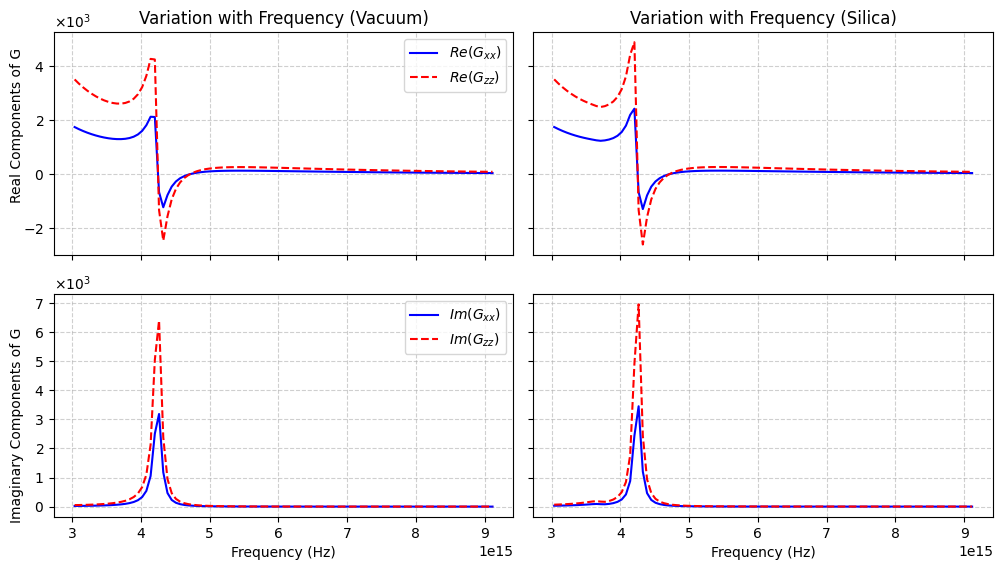

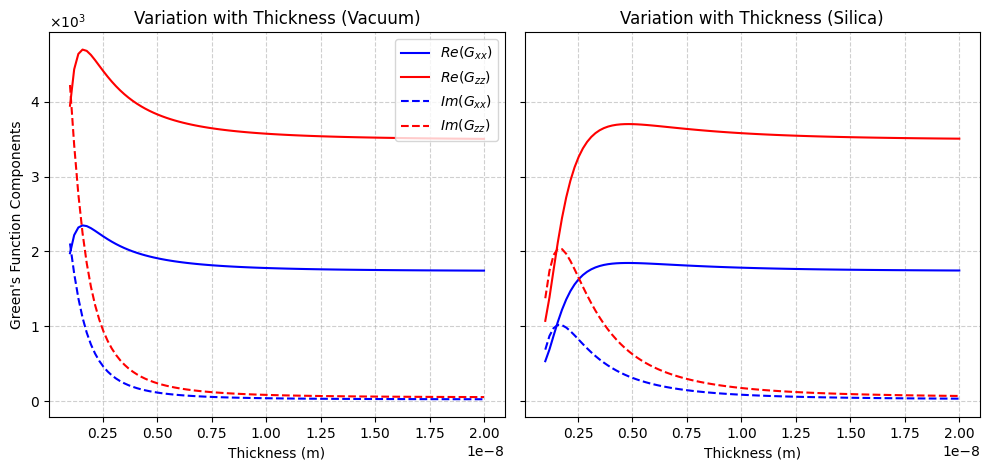

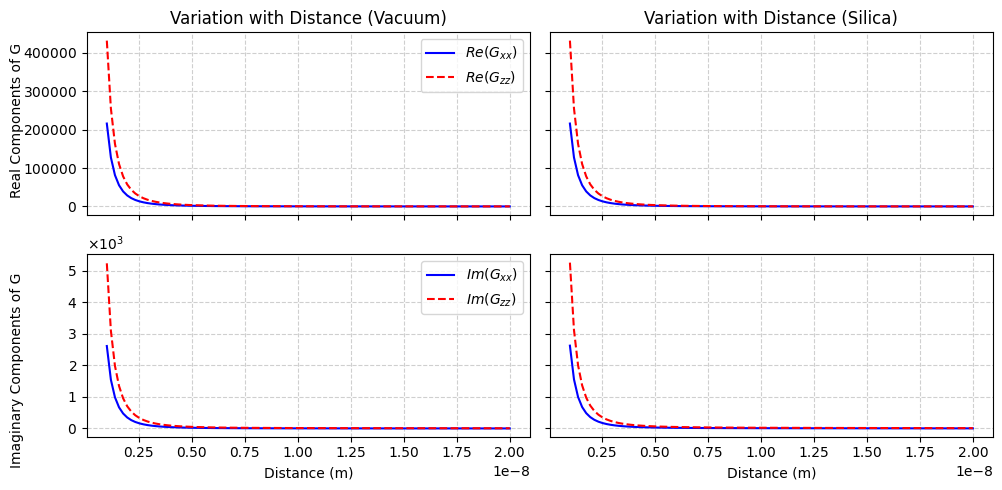

In [12]:
plot_results_w(w_values, "Frequency (Hz)", "Variation with Frequency", mediums)
plot_results_t(t_values, "Thickness (m)", "Variation with Thickness", mediums)
plot_results_z(z_values, "Distance (m)", "Variation with Distance", mediums)